# CHM Mapper - Canopy Height Model Cartographic Mapping

This notebook demonstrates how to create high-quality PDF maps from Canopy Height Model (CHM) GeoTIFF rasters with vector overlays.

## Features
- Clip CHM to forest compartments/inventory areas
- Classify heights into discrete classes
- Custom color schemes
- Vector boundary overlays
- Automatic map elements (title, legend, scale bar, north arrow)
- High-quality PDF export
- Batch processing capabilities

## 1. Setup and Imports

First, let's import all necessary libraries and our custom CHM mapper module.

In [ ]:
# Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Geospatial libraries
import rasterio
import geopandas as gpd

# Our custom CHM mapper from modules folder
# Use importlib to reload the module and pick up any code changes
import importlib
import modules.chm_mapper as chm_mapper
importlib.reload(chm_mapper)
from modules.chm_mapper import CHMMapper, create_chm_map

# Display settings for notebook
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

print("✓ All imports successful!")
print("✓ Module reloaded - any code changes are now active")

✓ All imports successful!
✓ Module reloaded - any code changes are now active


## 2. Define Your Data Paths

Update these paths to point to your actual data files. 

**Supported formats:**
- **CHM Raster:** GeoTIFF (.tif, .tiff)
- **Vector Boundaries:** Shapefile (.shp) or GeoPackage (.gpkg) - GeoPackage is recommended!

In [ ]:
# Path to your CHM GeoTIFF file
chm_path = r"data/chm_raster.tif"  # Update this path to your CHM file

# Path to your vector file (GeoPackage or Shapefile)
# GeoPackage (.gpkg) is recommended - single file, faster, no size limits
vector_path = r"data/forest_compartments.gpkg"  # Update this path to your vector file
# Or use shapefile: vector_path = r"data/forest_compartments.shp"

# Output directory
output_dir = r"output"
os.makedirs(output_dir, exist_ok=True)

print(f"CHM path: {chm_path}")
print(f"Vector path: {vector_path}")
print(f"Vector format: {'GeoPackage' if vector_path.endswith('.gpkg') else 'Shapefile' if vector_path.endswith('.shp') else 'Unknown'}")
print(f"Output directory: {output_dir}")

CHM path: D:\Drohnendaten\15_FESMART\01_Daten\05_AELF-NA\02_Data_output\02_Hirschbach\Clipped\20250811_Hirschbach-11-16_M3E_CHM.tif
Vector path: D:\Drohnendaten\15_FESMART\01_Daten\05_AELF-NA\00_Planung\hirschbach_fe-smart_flstk.gpkg
Vector format: GeoPackage
Output directory: D:\Drohnendaten\15_FESMART\01_Daten\05_AELF-NA\02_Data_output\02_Hirschbach\TEMP_chm_mapper_output


## 3. Quick Data Inspection

Let's quickly inspect the CHM raster and vector data to understand what we're working with.

In [50]:
# Inspect CHM raster
with rasterio.open(chm_path) as src:
    print("CHM Raster Information:")
    print(f"  CRS: {src.crs}")
    print(f"  Dimensions: {src.width} x {src.height}")
    print(f"  Bounds: {src.bounds}")
    print(f"  Resolution: {src.res}")
    print(f"  NoData value: {src.nodata}")
    
    # Read data with proper NoData masking
    chm_data = src.read(1, masked=True)  # masked=True handles NoData
    
    # Convert to regular array with NaN for NoData
    if hasattr(chm_data, 'filled'):
        chm_data = np.where(chm_data.mask, np.nan, chm_data.data)
    
    # Calculate statistics on valid data only
    valid_data = chm_data[~np.isnan(chm_data)]
    
    print(f"\n  Height range: {np.min(valid_data):.2f} - {np.max(valid_data):.2f} m")
    print(f"  Mean height: {np.mean(valid_data):.2f} m")
    print(f"  Median height: {np.median(valid_data):.2f} m")
    print(f"  Valid pixels: {len(valid_data):,} / {chm_data.size:,} ({len(valid_data)/chm_data.size*100:.1f}%)")

CHM Raster Information:
  CRS: EPSG:25832
  Dimensions: 3200 x 3835
  Bounds: BoundingBox(left=687797.227516687, bottom=5492815.232793283, right=687954.4035082926, top=5493003.598395722)
  Resolution: (0.04911749737677279, 0.0491174973766751)
  NoData value: -9999.0

  Height range: -0.69 - 32.44 m
  Mean height: 8.37 m
  Median height: 0.08 m
  Valid pixels: 9,726,682 / 12,272,000 (79.3%)


### 📊 Understanding the Data

The CHM now shows correct statistics with NoData values (-9999) properly excluded.

**Key observations:**
- Valid pixels show realistic tree heights (0-35m typical for forests)
- NoData areas (gaps in data) are excluded from calculations
- Mean/median heights are now meaningful for analysis

In [51]:
# Inspect vector data
if os.path.exists(vector_path):
    gdf = gpd.read_file(vector_path)
    print("Vector Data Information:")
    print(f"  CRS: {gdf.crs}")
    print(f"  Number of features: {len(gdf)}")
    print(f"  Columns: {list(gdf.columns)}")
    print(f"\nFirst few rows:")
    display(gdf.head())
else:
    print("Vector file not found - will proceed without vector overlay")

Vector Data Information:
  CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["GRS 1980",6378137,298.257222096042]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Number of features: 19
  Columns: ['oid_1', 'gmkgcode', 'zaehler', 'nenner', 'afl', 'lage', 'gemeinde', 'fkzid', 'zaeh_nenn', 'globalid', 'Shape_Leng', 'Shape_Area', 'geometry']

First few rows:


,oid_1,gmkgcode,zaehler,nenner,afl,lage,gemeinde,fkzid,zaeh_nenn,globalid,Shape_Leng,Shape_Area,geometry
0,DEBYvAAAAAARPm14,4467.0,386.0,2.0,5320.0,Steingrube,371128.0,094467___003860002__,386/2,{2821B338-FE09-4321-AA8E-6B478342DD71},371.122647,5339.04685,"MULTIPOLYGON Z (((689455.43 5495756.98 0, 6894..."
1,DEBYvAAAAAA6HeUh,4466.0,2586.0,2.0,9680.0,Der Stein,371128.0,094466___025860002__,2586/2,{5474B3E7-3EE1-4927-9102-6C91957EEED2},1337.335670,9756.61315,"MULTIPOLYGON Z (((689285.5 5496812.28 0, 68930..."
2,DEBYvAAAAAAQynJk,4477.0,778.0,2.0,14857.0,An der Hasenleite 1,371128.0,094477___007780002__,778/2,{B537000C-A51F-4D45-A9FF-90218F219585},745.627195,14862.10230,"MULTIPOLYGON Z (((682311.41 5491784.15 0, 6823..."
3,DEBYvAAAAAAQyrfv,4477.0,993.0,0.0,470.0,Hoher Berg,371128.0,094477___00993______,993/0,{74555C48-36E4-42A4-A674-77CC76DEEDD7},134.505918,532.91580,"MULTIPOLYGON Z (((682944.01 5492540.58 0, 6829..."
4,DEBYvAAAAAAQ7MRo,4466.0,441.0,0.0,12851.0,Deisleben,371128.0,094466___00441______,441/0,{4B6A7196-8E3D-4DF5-9279-CC88807C54F8},923.548368,12916.93775,"MULTIPOLYGON Z (((684870.64 5493449.27 0, 6848..."


### 🔍 Check Spatial Overlap

This cell checks if your vector geometries actually overlap with the CHM raster spatially.

In [52]:
# Check if vector and CHM overlap
if os.path.exists(vector_path):
    with rasterio.open(chm_path) as src:
        chm_bounds = src.bounds
        chm_crs = src.crs
    
    gdf = gpd.read_file(vector_path)
    
    print("Spatial Overlap Check:")
    print("=" * 60)
    print(f"CHM CRS: {chm_crs}")
    print(f"Vector CRS: {gdf.crs}")
    print(f"\nCHM bounds: {chm_bounds}")
    print(f"  (minx={chm_bounds.left:.2f}, miny={chm_bounds.bottom:.2f}, ")
    print(f"   maxx={chm_bounds.right:.2f}, maxy={chm_bounds.top:.2f})")
    
    # Reproject vector to CHM CRS for comparison
    if gdf.crs != chm_crs:
        print(f"\nReprojecting vector to CHM CRS...")
        gdf_reprojected = gdf.to_crs(chm_crs)
    else:
        gdf_reprojected = gdf
    
    # Check each geometry
    for idx, geom in enumerate(gdf_reprojected.geometry):
        geom_bounds = geom.bounds
        print(f"\nGeometry {idx} bounds: {geom_bounds}")
        print(f"  (minx={geom_bounds[0]:.2f}, miny={geom_bounds[1]:.2f}, ")
        print(f"   maxx={geom_bounds[2]:.2f}, maxy={geom_bounds[3]:.2f})")
        
        # Check overlap
        overlaps = not (geom_bounds[2] < chm_bounds.left or 
                       geom_bounds[0] > chm_bounds.right or
                       geom_bounds[3] < chm_bounds.bottom or 
                       geom_bounds[1] > chm_bounds.top)
        
        if overlaps:
            print(f"  ✓ Geometry {idx} OVERLAPS with CHM")
        else:
            print(f"  ✗ Geometry {idx} DOES NOT OVERLAP with CHM")
            print(f"    Distance from CHM:")
            if geom_bounds[0] > chm_bounds.right:
                print(f"      {geom_bounds[0] - chm_bounds.right:.2f}m to the EAST")
            if geom_bounds[2] < chm_bounds.left:
                print(f"      {chm_bounds.left - geom_bounds[2]:.2f}m to the WEST")
            if geom_bounds[1] > chm_bounds.top:
                print(f"      {geom_bounds[1] - chm_bounds.top:.2f}m to the NORTH")
            if geom_bounds[3] < chm_bounds.bottom:
                print(f"      {chm_bounds.bottom - geom_bounds[3]:.2f}m to the SOUTH")
    
    print("\n" + "=" * 60)
else:
    print("Vector file not found - skipping overlap check")

Spatial Overlap Check:
CHM CRS: EPSG:25832
Vector CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["GRS 1980",6378137,298.257222096042]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

CHM bounds: BoundingBox(left=687797.227516687, bottom=5492815.232793283, right=687954.4035082926, top=5493003.598395722)
  (minx=687797.23, miny=5492815.23, 
   maxx=687954.40, maxy=5493003.60)

Geometry 0 bounds: (689445.4501, 5495713.3101, 689538.9101, 5495845.3201)
  (minx=689445.45, miny=5495713.31, 
   maxx=689538.91, maxy=5495845.32)
  ✗ Geometry 0 DOES NOT OVERLAP with CHM
    Distance from CHM:
      1491.05m to the EAST
      2709.71m to the NO

### 🎯 Process Only Overlapping Geometries

Now let's create maps for the geometries that actually overlap with your CHM!

In [53]:
# Find which geometries overlap with CHM
if os.path.exists(vector_path):
    with rasterio.open(chm_path) as src:
        chm_bounds = src.bounds
        chm_crs = src.crs
    
    gdf = gpd.read_file(vector_path)
    
    # Reproject to CHM CRS if needed
    if gdf.crs != chm_crs:
        gdf_reprojected = gdf.to_crs(chm_crs)
    else:
        gdf_reprojected = gdf
    
    # Find overlapping geometries
    overlapping_indices = []
    
    for idx, geom in enumerate(gdf_reprojected.geometry):
        geom_bounds = geom.bounds
        overlaps = not (geom_bounds[2] < chm_bounds.left or 
                       geom_bounds[0] > chm_bounds.right or
                       geom_bounds[3] < chm_bounds.bottom or 
                       geom_bounds[1] > chm_bounds.top)
        if overlaps:
            overlapping_indices.append(idx)
    
    print(f"Found {len(overlapping_indices)} overlapping geometries: {overlapping_indices}")
    print(f"\nThese geometries will be processed:")
    for idx in overlapping_indices:
        # Show name if available
        if 'Name' in gdf.columns:
            name = gdf.iloc[idx]['Name']
            print(f"  Geometry {idx}: {name}")
        elif 'name' in gdf.columns:
            name = gdf.iloc[idx]['name']
            print(f"  Geometry {idx}: {name}")
        else:
            print(f"  Geometry {idx}")
    
    # Store for later use
    overlapping_geom_indices = overlapping_indices
else:
    print("Vector file not found")
    overlapping_geom_indices = []

Found 2 overlapping geometries: [10, 15]

These geometries will be processed:
  Geometry 10
  Geometry 15


## 4. Quick Visualization

Let's create a quick preview of the CHM data.

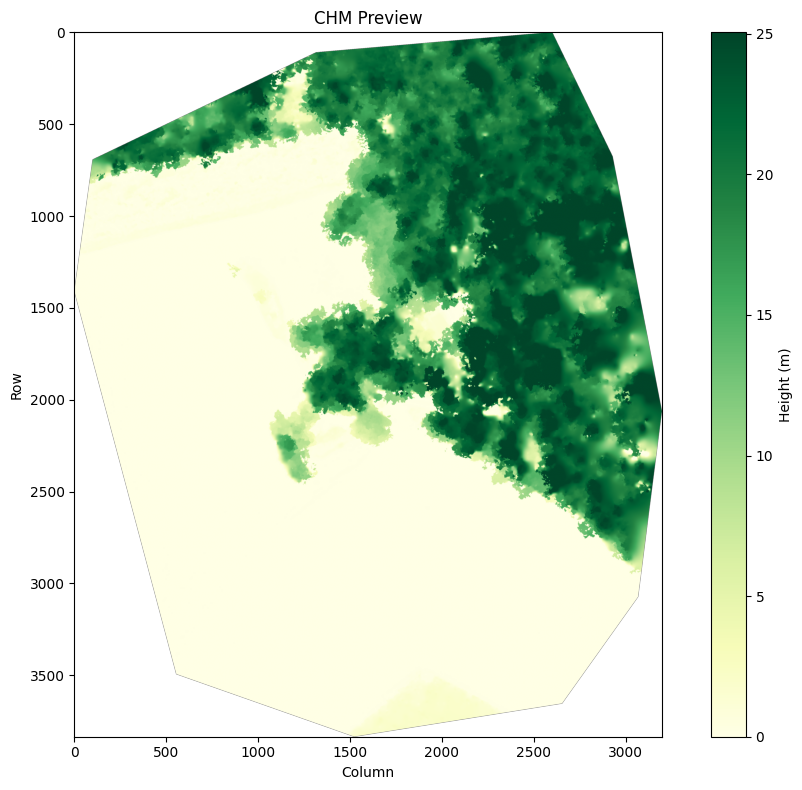

In [54]:
# Quick preview of CHM
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(chm_data, cmap='YlGn', vmin=0, vmax=np.nanpercentile(chm_data, 95))
plt.colorbar(im, ax=ax, label='Height (m)')
ax.set_title('CHM Preview')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.tight_layout()
plt.show()

## 5. Example 1: Production-Ready Map

Create a complete map with:
- Full CHM extent in landscape orientation
- Only the 2 overlapping vector polygons shown
- Overview/locator map ("Übersicht") below north arrow

In [79]:
# Map Element Configuration
# Adjust these values to change positions and sizes of map elements
MAP_CONFIG = {
    # ========== TEXT CONTENT (Change all text labels here!) ==========
    'title': 'Baumhöhenkarte',           # Main title text
    'subtitle': 'Am Birkach',            # Subtitle text
    'legend_title': 'Legende',  # Legend title text
    'legend_subtitle1': 'AFL 449, 623',              # First line below legend title (optional)
    'legend_subtitle2': 'Drohnenbefliegung 2025',              # Second line below legend title (optional)
    'overview_label': 'Übersicht',       # Text below overview map
    'location_name': 'Gemeinde Hirschbach',       # Text above overview map (use '' to hide)
    
    # ========== TITLE AND SUBTITLE ==========
    'title_fontsize': 16,
    'subtitle_fontsize': 11,
    'title_position_x': 0.82,  # Right side (0.5 = center, 1 = far right)
    'title_position_y': 0.95,  # Near top
    'title_align': 'left',     # Left-aligned text at x position
    
    # ========== LEGEND ==========
    'legend_fontsize': 8,
    'legend_title_fontsize': 11,
    'legend_subtitle_fontsize': 8,  # Font size for subtitle lines
    'legend_ncol': 1,          # Single column for right-side layout
    'legend_position_x': 0.88, # Right side
    'legend_position_y': 0.63, # Middle height
    'legend_loc': 'center',    # Anchor point
    
    # Legend size controls
    'legend_labelspacing': 0.8,    # Vertical space between entries (higher = taller)
    'legend_handlelength': 1.5,    # Width of color boxes (higher = wider boxes)
    'legend_handletextpad': 0.81,   # Space between box and text
    'legend_columnspacing': 1.0,   # Space between columns (if ncol > 1)
    'legend_border_linewidth': 0,  # Legend box border line thickness
    
    # Custom background box for legend (independent of matplotlib legend)
    'legend_background_box_x': 0.815,      # Left edge position (figure coords 0-1)
    'legend_background_box_y': 0.22,       # Bottom edge position (figure coords 0-1)
    'legend_background_box_width': 0.17,   # Box width (same as overview: 0.15)
    'legend_background_box_height': 0.56,  # Box height in figure coordinates
    'legend_background_box_linewidth': 1,  # Border line thickness
    
    # ========== NORTH ARROW (Independent positioning!) ==========
    'north_arrow_fontsize': 14,
    'north_arrow_position_x': 0.97,  # X position in figure coordinates (0-1)
    'north_arrow_position_y': 0.26,  # Y position in figure coordinates (0-1)
    'north_arrow_length': 0.015,     # Arrow length as % of figure height
    'north_arrow_width': 2,          # Arrow line thickness
    'north_arrow_pad': 0.3,          # Padding around 'N' text in box
    
    # ========== OVERVIEW/LOCATOR MAP ==========
    'overview_position_x': 0.90,     # X position (0-1, center of overview box)
    'overview_position_y': 0.27,     # Y position (0-1, bottom of overview box)
    'overview_width': 0.15,          # % of figure width
    'overview_height': 0.15,         # % of figure height
    'overview_fontsize': 7,          # "Übersicht" label size
    'overview_border_width': 0.8,      # Border thickness around overview
    'overview_chm_box_width': 1.5,   # Red box thickness showing CHM extent
    
    # Location name text (above overview map)
    'location_fontsize': 10,         # Font size for location name
    'location_y_offset': 0.005,      # Space between overview and location text
    
    # ========== SCALE BAR ==========
    'scalebar_fontsize': 9,
    'scalebar_height': 0.015,        # % of figure height
    'scalebar_length': 0.2,          # % of map width
    'scalebar_location': 'lower right',  # Position: 'lower right', 'upper left', etc.
    'scalebar_pad_x': 0.5,           # Horizontal padding from edge
    'scalebar_pad_y': 0.5,           # Vertical padding from edge
    
    # ========== SCALE TEXT ("Maßstab 1:xxxx") ==========
    'scale_text_fontsize': 10,       # Font size for scale text
    'scale_text_position_x': 0.91,   # X position (0-1, figure coordinates)
    'scale_text_position_y': 0.02,   # Y position (0-1, figure coordinates)
    'scale_text_align': 'left',      # Text alignment: 'left', 'center', 'right'
    
    # ========== VISUAL STYLING ==========
    'vector_linewidth': 1.5,         # Vector boundary line thickness
    'border_linewidth': 0,           # Map border thickness
    
    # ========== MAP POSITION ON PAGE ==========
    'map_left': 0.02,     # Distance from left edge
    'map_right': 0.8,     # Map ends at 80% (leaves 20% for right elements)
    'map_top': 0.98,      # Distance from top edge
    'map_bottom': 0.02,   # Distance from bottom edge
    
    # ========== DEBUGGING ==========
    'show_box_border': True  # Set to True to see axes box extent
}

print("✓ Configuration loaded")
print("Adjust values above and re-run the production map cell to see changes")

✓ Configuration loaded
Adjust values above and re-run the production map cell to see changes


### ⚙️ Map Layout Configuration

Adjust these values to customize the map appearance. After changing values, re-run the production map cell below.

In [80]:
# Create production-ready map with overlapping vectors and overview map
output_path = os.path.join(output_dir, "chm_map_production.pdf")

# Initialize mapper 
mapper = CHMMapper(chm_path, vector_path)
mapper.load_data()
# Note: mapper.vector_gdf_full is automatically stored with ALL vectors for overview

# Filter main map to show only overlapping geometries (from Cell 13)
if 'overlapping_geom_indices' in locals() and len(overlapping_geom_indices) > 0:
    # Keep only overlapping geometries for main map display
    mapper.vector_gdf = mapper.vector_gdf.iloc[overlapping_geom_indices].copy()
    print(f"Main map: Using {len(mapper.vector_gdf)} overlapping polygons")
    print(f"Overview map: Will show all {len(mapper.vector_gdf_full)} polygons")
else:
    print("⚠ Run Cell 13 first to identify overlapping geometries")

# Create map in landscape orientation with overview (using configuration from above)
mapper.create_map(
    data=mapper.chm_data,
    transform=mapper.chm_transform,
    bounds=mapper.chm_bounds,
    title="Baumhöhenkarte",
    subtitle="Am Birkach",
    output_path=output_path,
    figsize=(16.53, 11.69),  # A3 landscape (width=16.53, height=11.69)
    dpi=300,
    add_overview=True,  # Include overview/locator map with ALL vectors
    config=MAP_CONFIG if 'MAP_CONFIG' in locals() else None  # Use config if available
)

print(f"✓ Map saved to: {output_path}")
print(f"\n📁 PDF Location: {output_path}")

# Try to display the PDF in the notebook
try:
    from pdf2image import convert_from_path
    import matplotlib.pyplot as plt
    
    print("Converting PDF to image for preview...")
    
    # For Windows, pdf2image needs poppler
    # Try to convert - will auto-find poppler if installed correctly
    images = convert_from_path(output_path, first_page=1, last_page=1, dpi=120)
    
    # Display the image
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(images[0])
    ax.axis('off')
    plt.title('Generated Map Preview (Click to zoom)', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()
    
    print("✓ Preview displayed above")
    
except ImportError as e:
    print(f"\n⚠ Cannot display preview - missing dependency:")
    print(f"   {e}")
    print(f"\n💡 To enable preview, install:")
    print(f"   pip install pdf2image")
    print(f"   conda install -c conda-forge poppler")
    print(f"\n📄 Open the PDF file manually from the path above")
    
except Exception as e:
    print(f"\n⚠ Could not display preview: {e}")
    print(f"   This is usually because poppler is not in PATH")
    print(f"\n💡 Install poppler:")
    print(f"   conda install -c conda-forge poppler")
    print(f"   OR download from: https://github.com/oschwartz10612/poppler-windows/releases/")
    print(f"\n📄 Open the PDF file manually from the path above")

  Vector CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["GRS 1980",6378137,298.257222096042]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  CHM CRS: EPSG:25832
  → CRS match, no reprojection needed
Main map: Using 2 overlapping polygons
Overview map: Will show all 19 polygons
Map saved to: D:\Drohnendaten\15_FESMART\01_Daten\05_AELF-NA\02_Data_output\02_Hirschbach\TEMP_chm_mapper_output\chm_map_production.pdf
✓ Map saved to: D:\Drohnendaten\15_FESMART\01_Daten\05_AELF-NA\02_Data_output\02_Hirschbach\TEMP_chm_mapper_output\chm_map_production.pdf

📁 PDF Location: D:\Drohnendaten\15_FESMART\01_Daten\05_AELF-NA\02_Data_output\02_Hirs